In [1]:
filename_weather = "3964117.csv"
#filename_green = "ukr-ndvi-adm2-full.csv"
filename_green = "ilocos-sur-green.csv"
#start = 2006
#end = 2021

In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV
from filterpy.kalman import KalmanFilter

In [3]:
start_year=2004
end_year=2024
df = pd.read_csv(filename_weather)
df = df.drop(columns=['GUST', 'SNDP', 'STP', 'SLP'])
df = df.replace(999.9, pd.NA)
df = df.replace(9999.9, pd.NA)
df['PRCP'] = df['PRCP'].replace(99.99, pd.NA)
df['DATE'] = pd.to_datetime(df['DATE'])
df = df[(df['DATE'].dt.year >= start_year) & (df['DATE'].dt.year <= end_year)]
df = df[~((df['DATE'].dt.month == 2) & (df['DATE'].dt.day == 29))]
df = df.ffill()
df = df.sort_values("DATE")
df

/var/folders/gx/9rfpwcnn3nv1fbw39974s9vh0000gn/T/ipykernel_23996/1208446071.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill()


,STATION,DATE,DEWP,FRSHTT,MAX,MIN,MXSPD,PRCP,TEMP,VISIB,WDSP
7234,62840099999,2004-01-01,49.3,0,101.3,65.3,11.1,0.0,84.5,12.4,6.4
7235,62840099999,2004-01-02,48.7,0,100.4,70.7,5.8,0.0,85.3,12.4,4.2
7236,62840099999,2004-01-06,48.7,0,101.3,78.8,7.0,0.0,94.6,12.4,2.0
7237,62840099999,2004-01-07,60.4,0,104.0,74.3,5.1,0.0,80.7,12.4,3.7
7238,62840099999,2004-01-08,45.0,0,91.4,76.1,7.0,0.0,80.6,10.1,5.5
...,...,...,...,...,...,...,...,...,...,...,...
2880,62941099999,2024-01-13,48.7,0,95.0,75.2,6.0,0.0,87.8,4.3,4.0
2881,62941099999,2024-01-22,37.4,0,96.8,77.0,7.0,0.0,90.1,12.6,4.5
2882,62941099999,2024-01-31,44.6,100000,95.0,77.0,4.1,0.0,87.8,2.5,2.2
2883,62941099999,2024-03-21,56.8,0,100.4,86.0,6.0,0.0,95.5,6.2,3.7


In [4]:
class WeatherModel():
    def __init__(self, filename, start_year=2004, end_year=2024):
        self.data = pd.read_csv(filename)
        self.data = self.data.drop(columns=['GUST', 'SNDP', 'STP', 'SLP'])
        #self.data = self.data.drop(columns=['GUST', 'SNDP', 'SLP', 'STP', "DEWP"])
        self.data = self.data.replace(999.9, pd.NA)
        self.data = self.data.replace(9999.9, pd.NA)
        self.data['PRCP'] = self.data['PRCP'].replace(99.99, pd.NA)
        self.data['DATE'] = pd.to_datetime(self.data['DATE'])
        self.data = self.data[(self.data['DATE'].dt.year >= start_year) & (self.data['DATE'].dt.year <= end_year)]
        self.data = self.data[~((self.data['DATE'].dt.month == 2) & (self.data['DATE'].dt.day == 29))]
        self.data = self.data.sort_values("DATE")
        self.data = self.data.ffill()

        self.seasonal = None
        self.residuals = None

        self.year_data = self.get_year_data()
        self.arma_models = []

    def get_year_data(self):
        data = self.data[["MAX", "MIN", "TEMP", "MXSPD", "PRCP", "WDSP", "DEWP"]]#"SLP", 
        data = data.to_numpy()

        drop_rows = data.shape[0] % 365
        data = data[:-drop_rows]

        data = data.reshape(-1, 365, data.shape[1])

        return data

    def get_seasonal_trend(self):
        
        seasonal = np.mean(self.year_data, axis=0)
        self.seasonal = seasonal

        return seasonal
    
    def get_residuals(self):
        
        if self.seasonal is None:
            self.get_seasonal_trend()

        residuals = self.year_data - self.seasonal
        residuals = residuals.reshape(-1, residuals.shape[2])
        self.residuals = residuals

        return residuals
    
    def fit_arma(self, order, train_stop = None):

        if train_stop is None:

            if self.residuals is None:
                self.get_residuals()

            arma_models = []

            pbar = tqdm(total=self.residuals.shape[1])

            for i in range(self.residuals.shape[1]):
                pbar.set_description(f"Fitting {i+1}/{self.residuals.shape[1]} ARMA models")
                pbar.update(1)
                model = ARIMA(self.residuals[:, i], order=order)
                model_fit = model.fit()
                arma_models.append(model_fit)
                
            self.arma_models = arma_models

            return None
        else:

            if self.residuals is None:
                self.get_residuals()

            arma_models = []

            pbar = tqdm(total=self.residuals[:,train_stop].shape[1])

            for i in range(self.residuals.shape[:,train_stop][1]):
                pbar.set_description(f"Fitting {i+1}/{self.residuals.shape[1]} ARMA models")
                pbar.update(1)
                model = ARIMA(self.residuals[:, i], order=order)
                model_fit = model[:,train_stop].fit()
                arma_models.append(model_fit)
                
            self.arma_models = arma_models

            return None

    def fit(self, order):
        self.fit_arma(order)
        return None
    
    # def fit(self, p,q, train_stop = None):
    #     self.fit_arma(order = (p,0,q), train_stop)
        # return None

    # def Grid(self):
    #     dict_for_GS = dict()
    #     dict_for_GS[p0] = [0,1,2,3,4,5,6,7]
    #     dict_for_GS[q0] = [0,1,2,3,4,5,6,7]
    #     GS = GridSearchCV(wm.fit, dict_for_GS, n_jobs = -1)
    #     GS.f=best_score
    #     wm.fit(1,0,1)
    #     models = wm.arma_models
    
    def predict(self, start=0, future=0):
        if len(self.arma_models) == 0:
            raise ValueError("Model not fitted yet")

        arma_predictions = np.array([model.predict(start=start, end=len(self.residuals) - start + future) for model in self.arma_models])

        season_start = start % 365
                
        num_stacks = arma_predictions.shape[1] // self.seasonal.shape[0]
        num_extras = arma_predictions.shape[1] % self.seasonal.shape[0]


        seasonal_predictions = np.vstack([self.seasonal for _ in range(num_stacks)])
        print("Seasonal Predictions", seasonal_predictions.shape)
        print("Residual shape", arma_predictions.shape)
        print("Num stacks", num_stacks)
        print("Num extras", num_extras)

        if num_extras > 0:
            seasonal_predictions = np.vstack((seasonal_predictions, self.seasonal[:num_extras].reshape(num_extras, -1)))



        return seasonal_predictions.T + arma_predictions
    



In [5]:
wm = WeatherModel(filename_weather)

#Defining score for model
def score(model):
    return ([model[i].aic for i in range(len(model))])

# dict_for_GS = dict()
# dict_for_GS["p0"] = [0,1,2,3,4,5,6,7]
# dict_for_GS["q0"] = [0,1,2,3,4,5,6,7]
# GS = GridSearchCV(wm, dict_for_GS, n_jobs = -1, scoring = score)
# GS.fit(wm.data)
# #GS.f = best_score
# models = wm.arma_models

#Making values to look over
wm = WeatherModel(filename_weather)


wm.fit(order=(1, 0, 1))

/var/folders/gx/9rfpwcnn3nv1fbw39974s9vh0000gn/T/ipykernel_23996/4095630191.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.data = self.data.ffill()
/var/folders/gx/9rfpwcnn3nv1fbw39974s9vh0000gn/T/ipykernel_23996/4095630191.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.data = self.data.ffill()
Fitting 7/7 ARMA models: 100%|████████████████████| 7/7 [00:00<00:00,  7.31it/s]


In [6]:
predictions = wm.predict(start=0, future=365*10)

Seasonal Predictions (5110, 7)
Residual shape (7, 5111)
Num stacks 14
Num extras 1


(7, 5111)
(7, 1460)


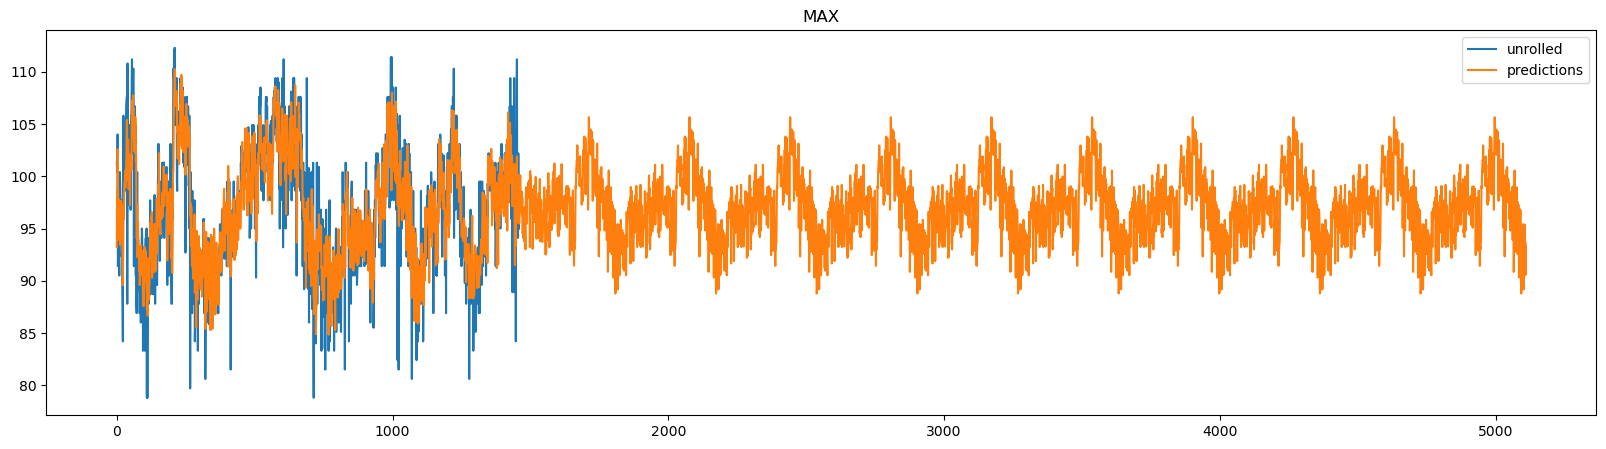

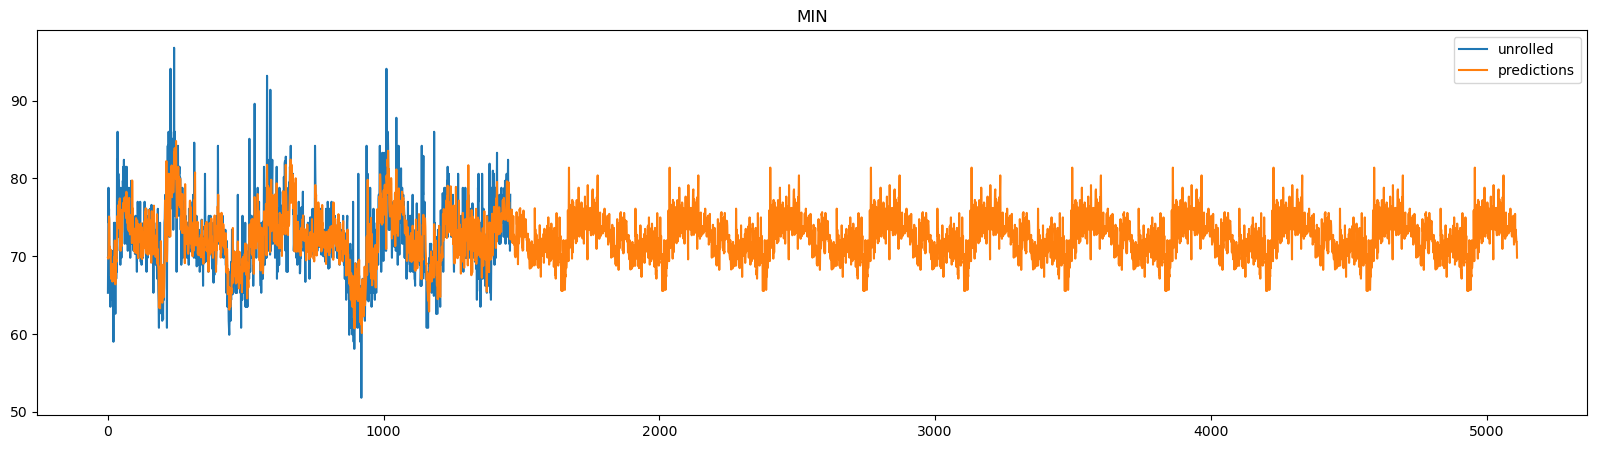

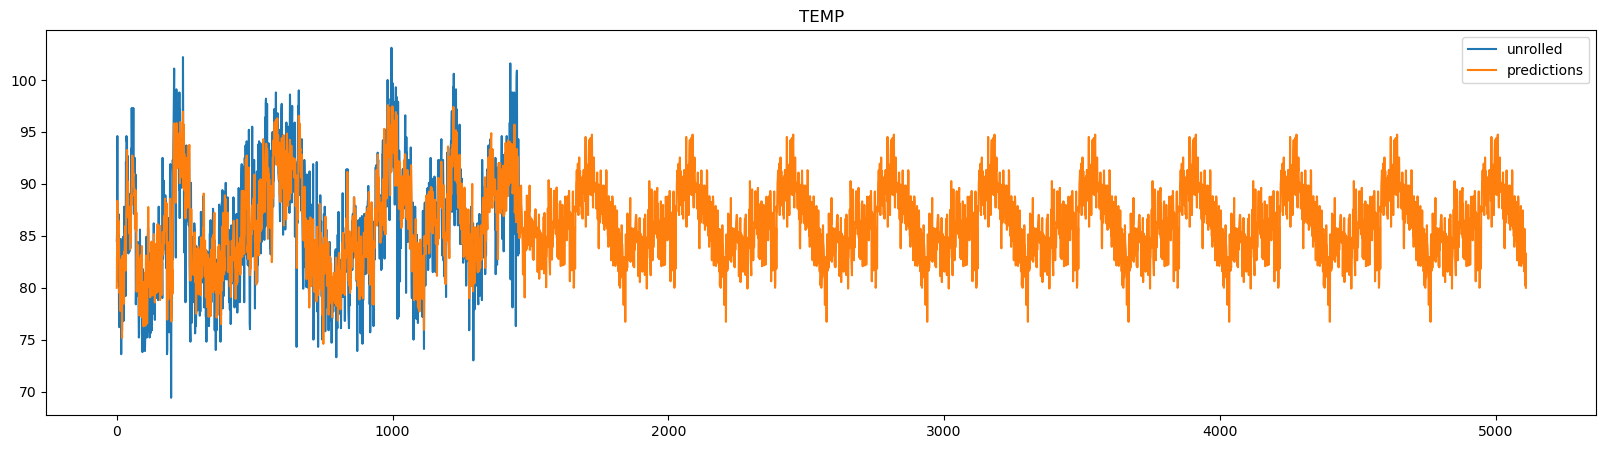

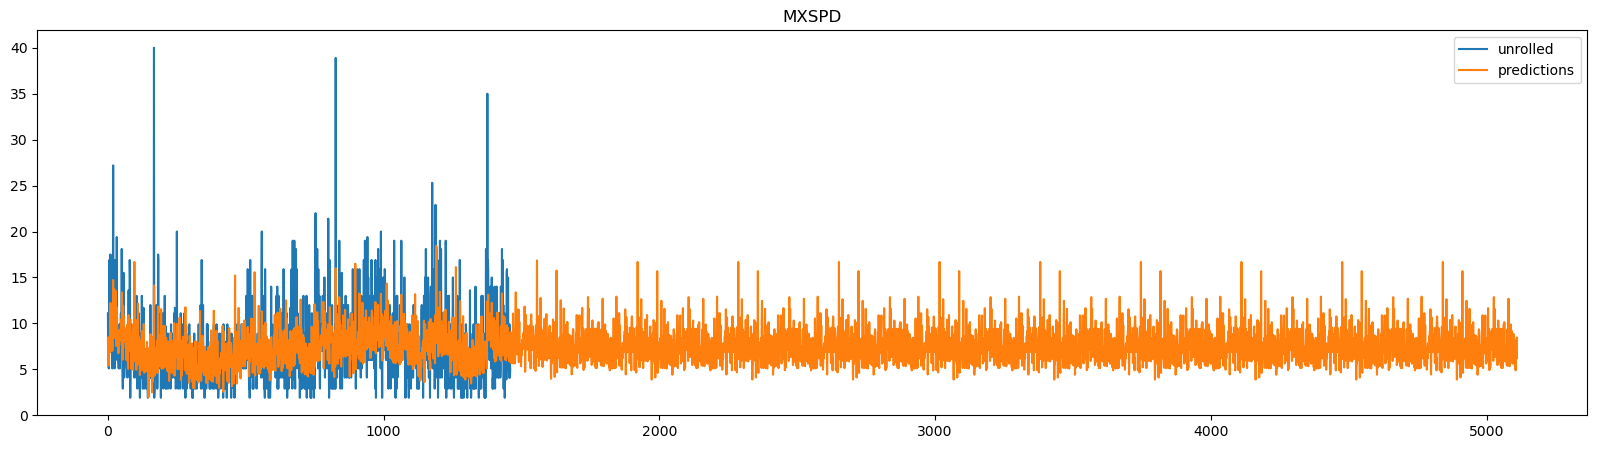

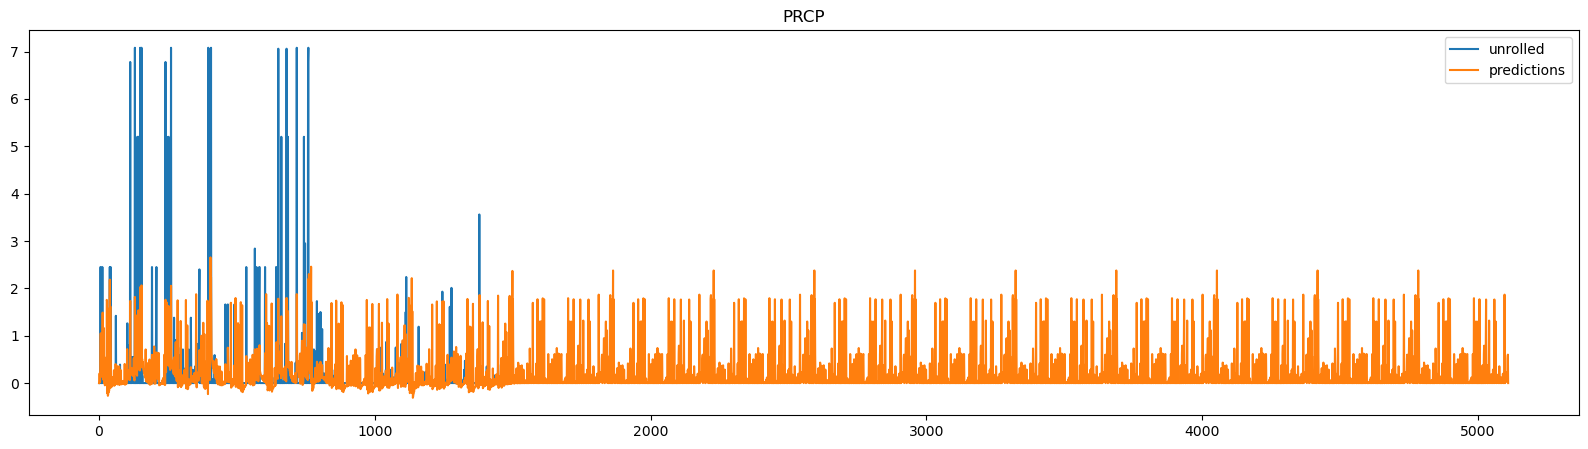

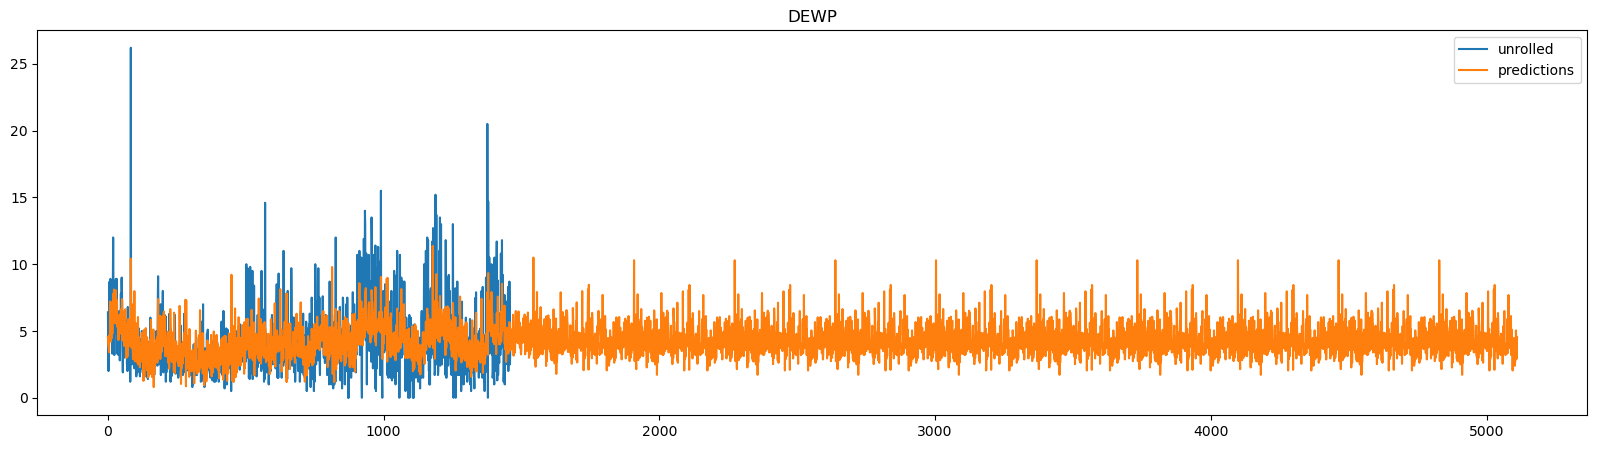

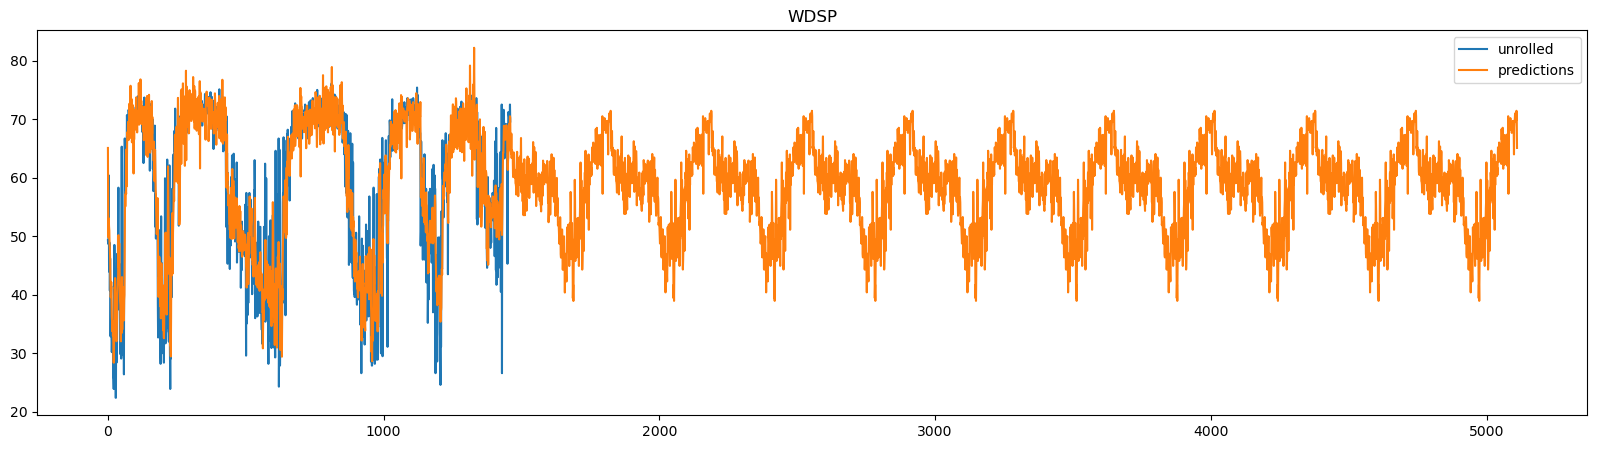

In [7]:
print(predictions.shape)

unrolled_data = wm.year_data.reshape(-1, wm.year_data.shape[2]).T
print(unrolled_data.shape)
feature_names = ["MAX", "MIN", "TEMP", "MXSPD", "PRCP", "DEWP", "WDSP"]
for i in range(len(predictions)):
    plt.figure(figsize=(20, 5))
    plt.title(feature_names[i])
    plt.plot(unrolled_data[i], label="unrolled")
    plt.plot(predictions[i], label="predictions")
    plt.legend()
    plt.show()


In [8]:
print(feature_names)
print(len(feature_names))

['MAX', 'MIN', 'TEMP', 'MXSPD', 'PRCP', 'DEWP', 'WDSP']
7


In [9]:
print(unrolled_data)
print(unrolled_data.shape)
actual = unrolled_data[0]
actual

[[101.3  100.4  101.3  ...  97.7   97.7   95.  ]
 [ 65.3   70.7   78.8  ...  75.2   70.7   77.9 ]
 [ 84.5   85.3   94.6  ...  90.1   83.3   88.7 ]
 ...
 [  0.     0.     0.   ...   0.     0.35   0.  ]
 [  6.4    4.2    2.   ...   5.     2.5    3.5 ]
 [ 49.3   48.7   48.7  ...  69.8   72.5   69.6 ]]
(7, 1460)


array([101.3, 100.4, 101.3, ...,  97.7,  97.7,  95. ])

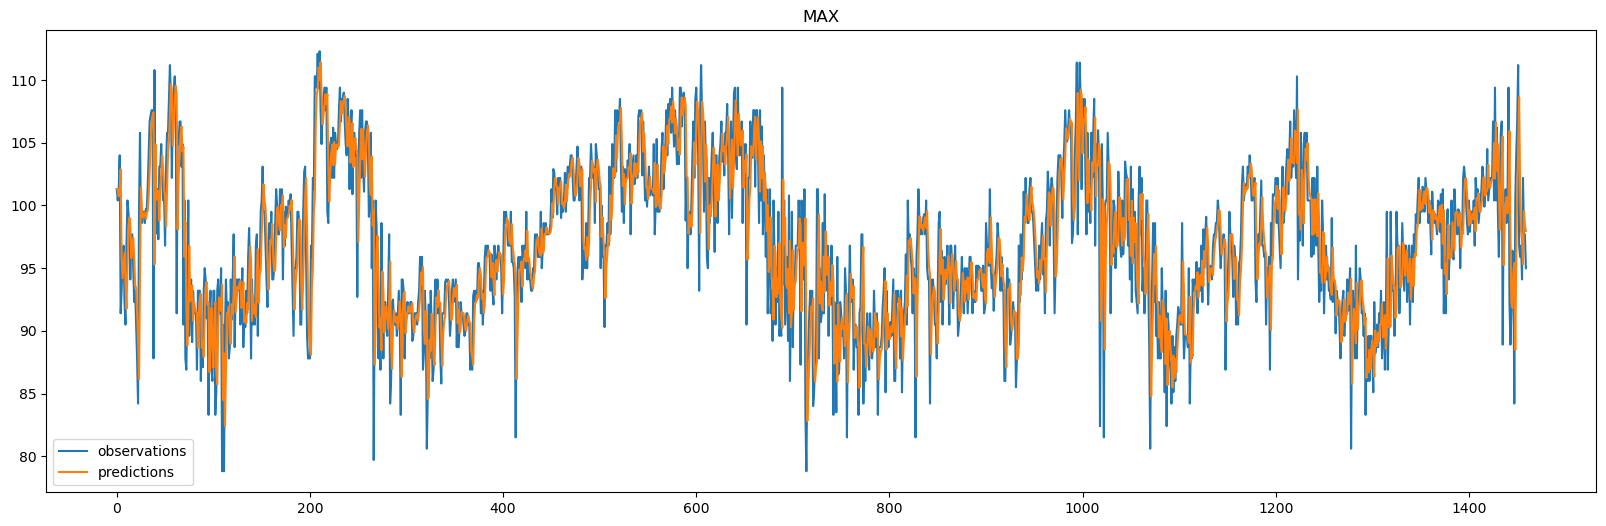

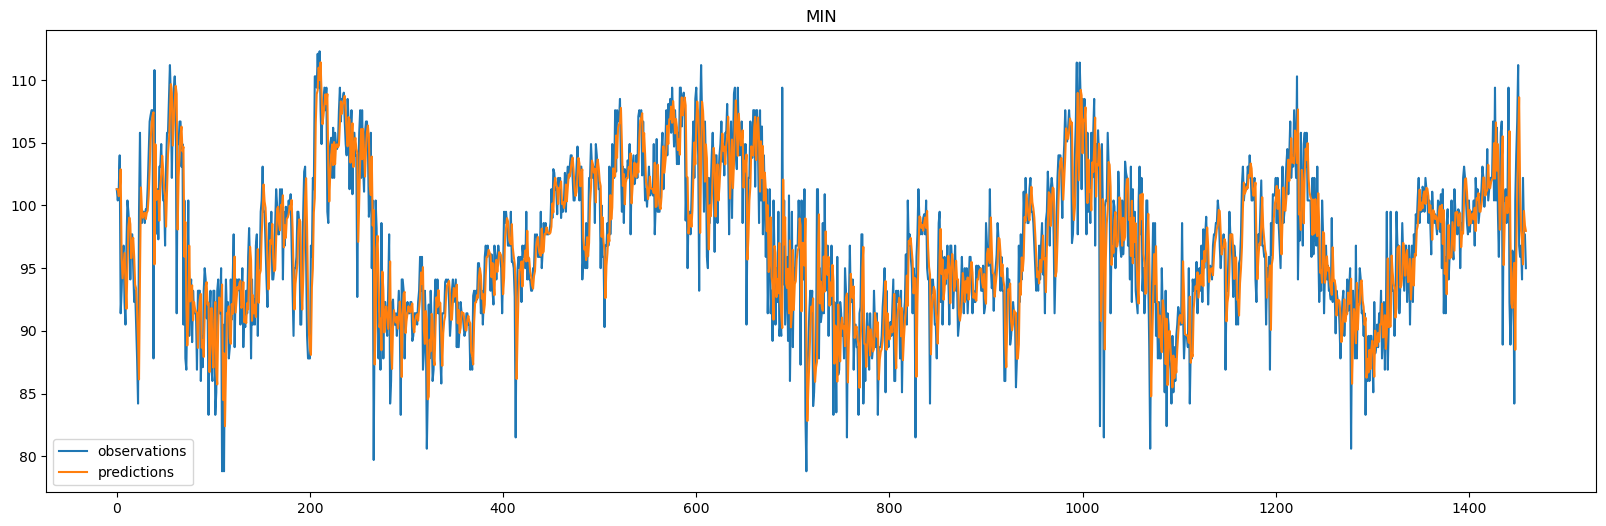

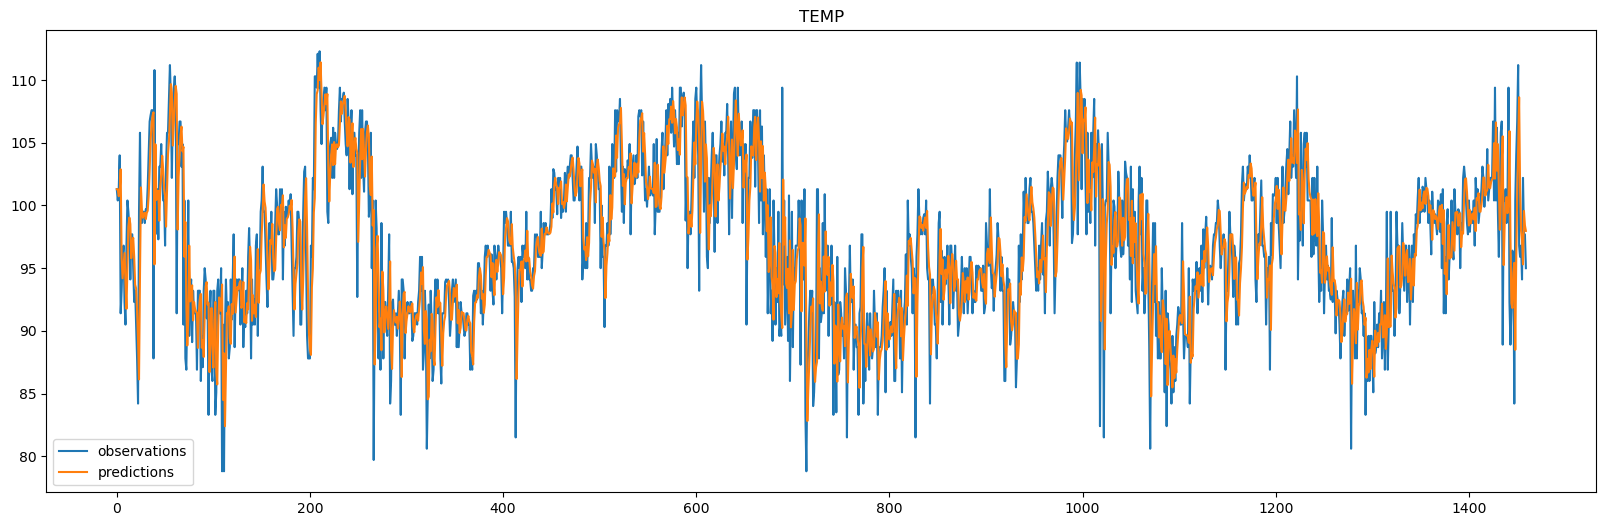

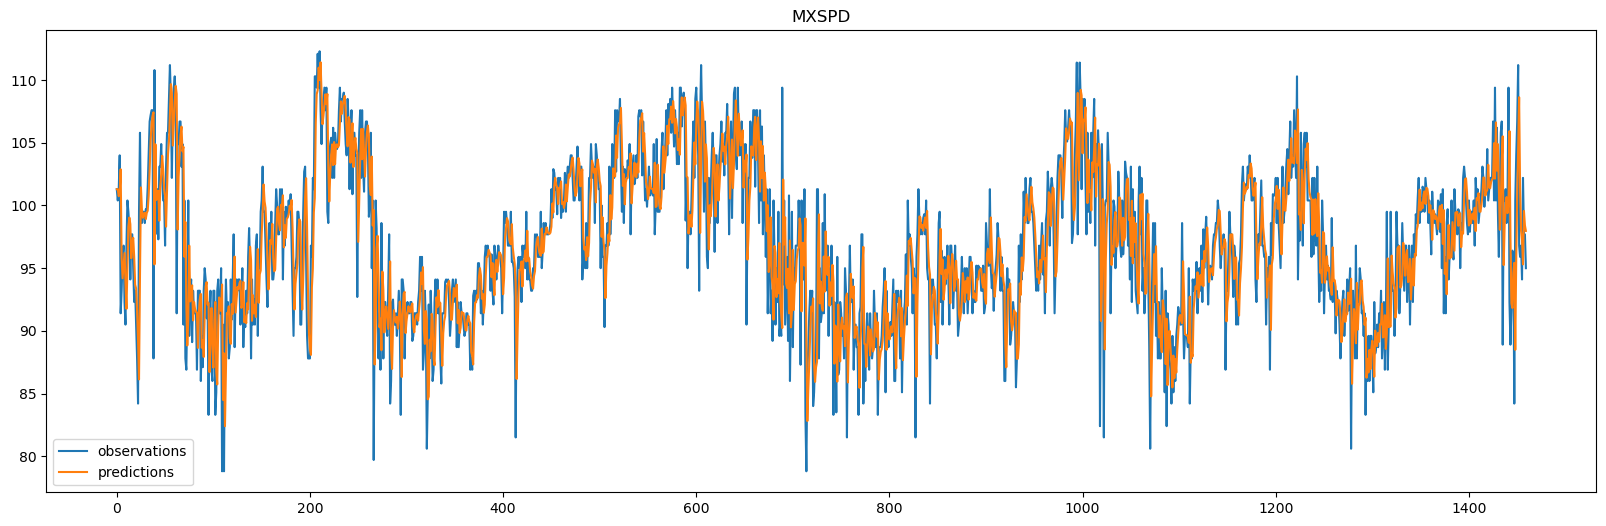

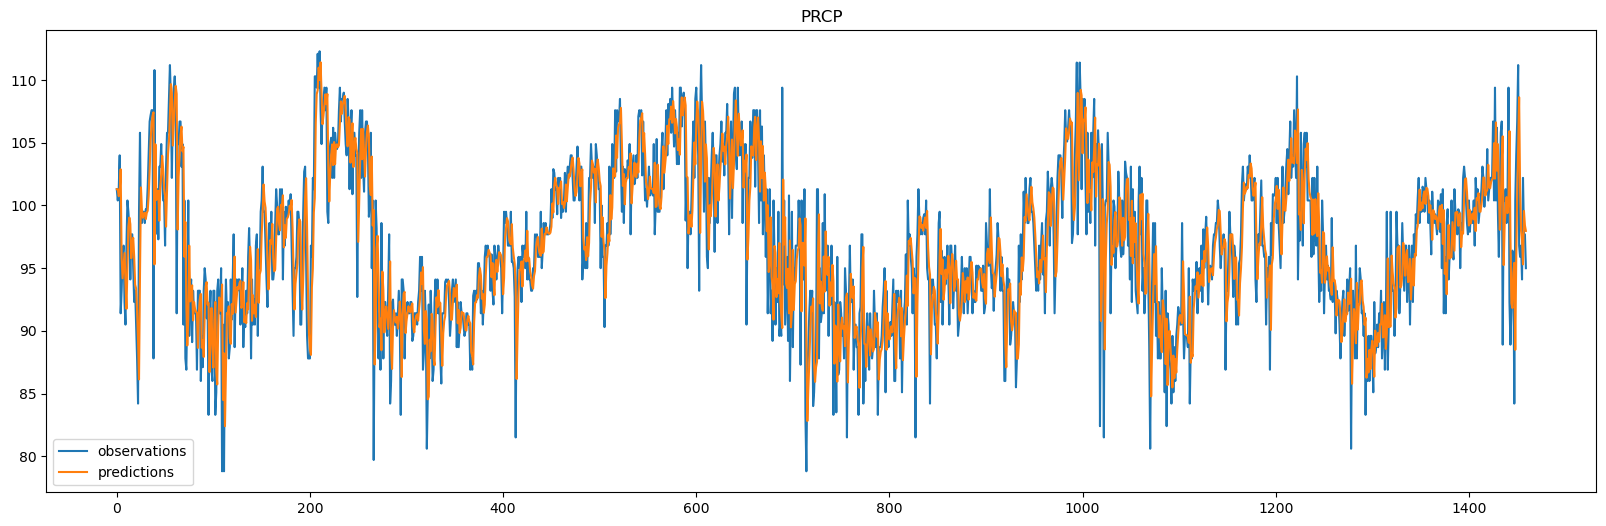

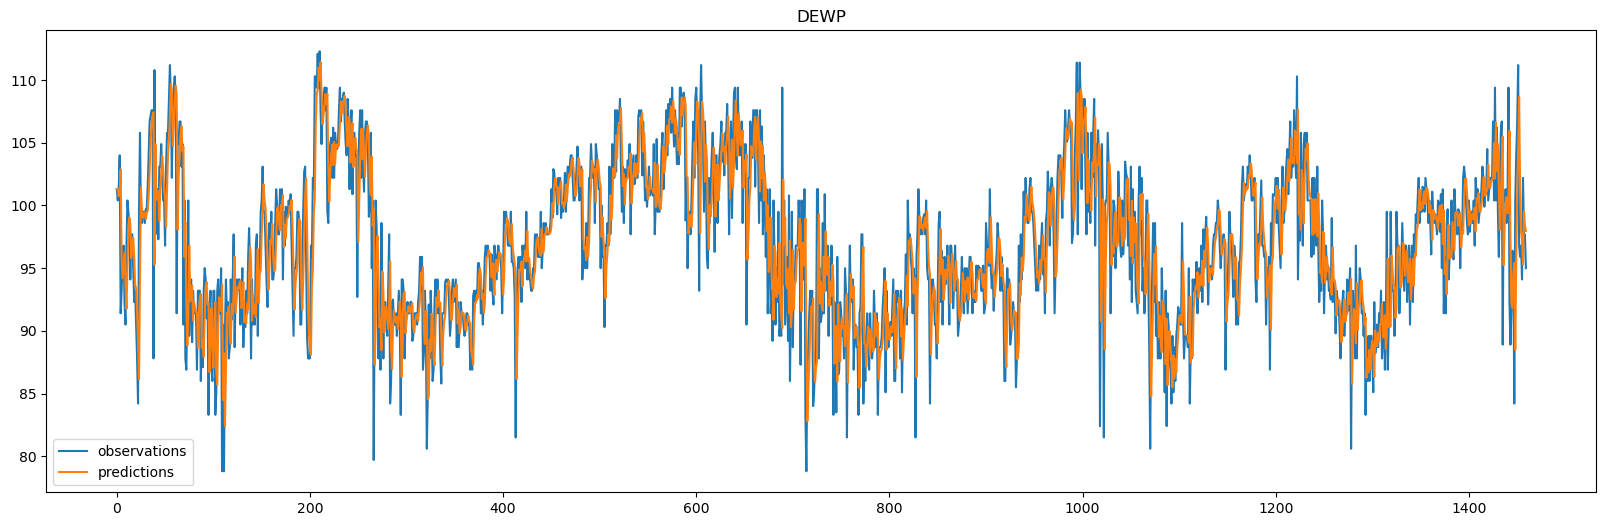

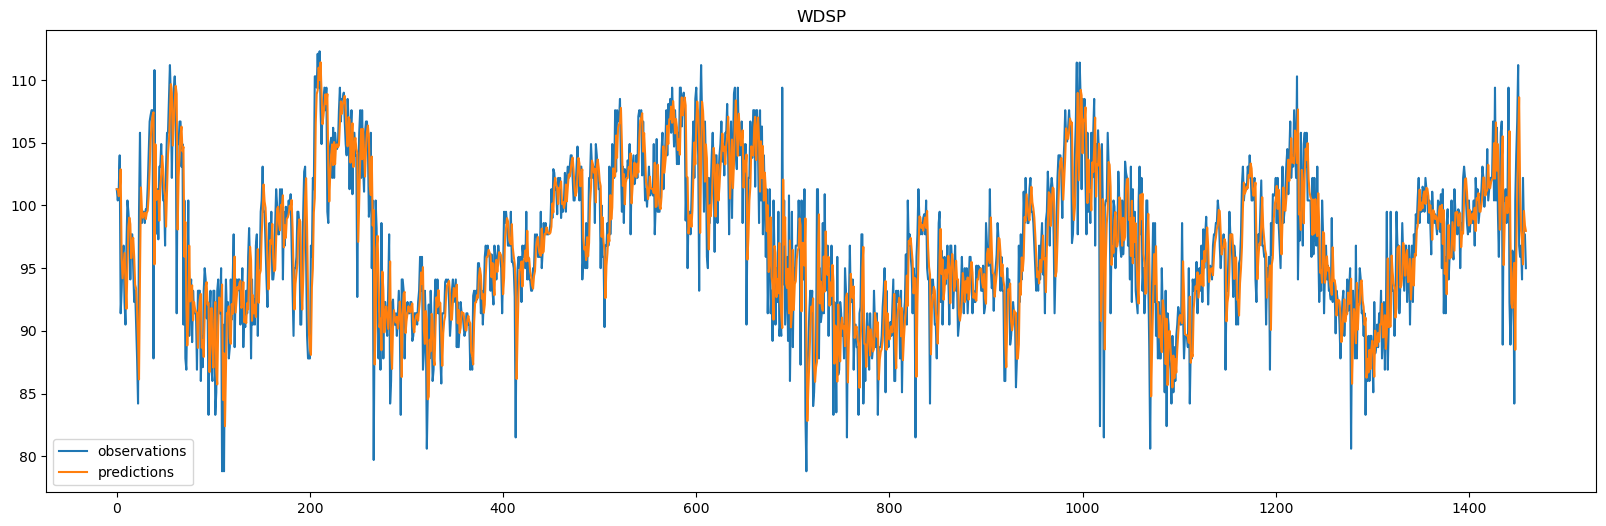

In [13]:
for j in feature_names:

    f = KalmanFilter(dim_x=1, dim_z=1)
    f.x = actual[0]
    f.F = np.eye(1)
    f.H = np.eye(1)

    predictions = []
    for i in range(len(actual)):
        f.predict()
        predictions.append(f.x[0][0])
        f.update(actual[i])

    plt.figure(figsize=(20, 6))
    plt.title(j)
    plt.plot(actual, label="observations")
    plt.plot(predictions, label="predictions")
    plt.legend()
    plt.show()